In [69]:
import pandas as pd
import numpy as np
import tqdm # interactive progress bar

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
train_df = pd.read_csv('data/final_train.csv')

In [71]:
print(train_df.shape)

(5405, 2)


In [72]:
train_df['up_class'].value_counts(normalize=True)

1    0.548566
0    0.451434
Name: up_class, dtype: float64

In [73]:
review_summaries = list(train_df['content'].values)
review_summaries = [l.lower() for l in review_summaries]

In [74]:
len(review_summaries)

5405

In [75]:
review_summaries[:5]

['главное по секторам российского рынка   нефтегазовый сектор  buy. все внимание инвесторов приковано к очередному собранию опек+, которое пройдет уже ноября. а пока нефть продолжает находиться вблизи 7-летних максимумов на фоне сохранения сильного спроса.    уран  buy. повестка развития атомной энергетики продолжает набирать обороты. уже европейских стран поддерживают включение атомной энергетики в список зеленых источников энергии. китай планирует построить еще ядерных реакторов к году, это в раза больше, чем есть в стране сейчас.   сельхоз сектор  buy. из-за энергокризиса в европе резко выросли цены на удобрения. это может привести к снижению урожайности и еще большему росту цен на сельхозпродукцию. российские аграрии выигрывают от роста цен на удобрения, так как договорились с производителями о фиксации цен до конца года.   девелопмент  buy. российский рынок недвижимости имеет кратный потенциал роста - низкая обеспеченность кв.м. и старый жилищный фонд. в следующие лет спрос на нед

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [92]:
vectorizer = TfidfVectorizer()
tfidfed = vectorizer.fit_transform(review_summaries)
tfidfed.shape

(5405, 19175)

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
X = tfidfed
y = train_df['up_class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [95]:
from dmia.gradient_check import *
from dmia.classifiers.logistic_regression import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [82]:
X_train_sample = X_train[:1000]
y_train_sample = y_train[:1000]
clf = LogisticRegression()
clf.w = np.random.randn(X_train_sample.shape[1]+1) * 2
loss, grad = clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)

print(loss)
print(grad)
print(np.unique(grad))

1.4187189591573302
[-5.16852997e-05  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  2.78749133e-01]
[-0.00083049 -0.00081173 -0.00073613 ...  0.01386871  0.03042102
  0.27874913]


In [83]:
# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, clf.w, grad, 10)

numerical: 0.000193 analytic: 0.000193, relative error: 4.319142e-08
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000091 analytic: 0.000091, relative error: 9.912909e-08
numerical: -0.000319 analytic: -0.000319, relative error: 3.873322e-09
numerical: 0.000111 analytic: 0.000111, relative error: 5.399079e-08
numerical: 0.000213 analytic: 0.000213, relative error: 4.056570e-08
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.000041 analytic: -0.000041, relative error: 1.876432e-07
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan


d:\program1\Projects\Lemtuznicova news\forecast\dmia\gradient_check.py:51: RuntimeWarning: invalid value encountered in double_scalars
  abs(grad_numerical) + abs(grad_analytic))
d:\program1\Projects\Lemtuznicova news\forecast\dmia\gradient_check.py:51: RuntimeWarning: invalid value encountered in double_scalars
  abs(grad_numerical) + abs(grad_analytic))
d:\program1\Projects\Lemtuznicova news\forecast\dmia\gradient_check.py:51: RuntimeWarning: invalid value encountered in double_scalars
  abs(grad_numerical) + abs(grad_analytic))
d:\program1\Projects\Lemtuznicova news\forecast\dmia\gradient_check.py:51: RuntimeWarning: invalid value encountered in double_scalars
  abs(grad_numerical) + abs(grad_analytic))


In [84]:
print(X_train.shape)

(3783, 19175)


In [108]:
clf = LogisticRegression()
train_scores = []
test_scores = []
num_iters = 10000

for i in tqdm.trange(num_iters):
    # Сделайте один шаг градиентного спуска с помощью num_iters=1
    clf.train(X_train, y_train, learning_rate=1.0, num_iters=1, batch_size=256, reg=1e-3)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

100%|██████████| 10000/10000 [04:06<00:00, 40.57it/s]


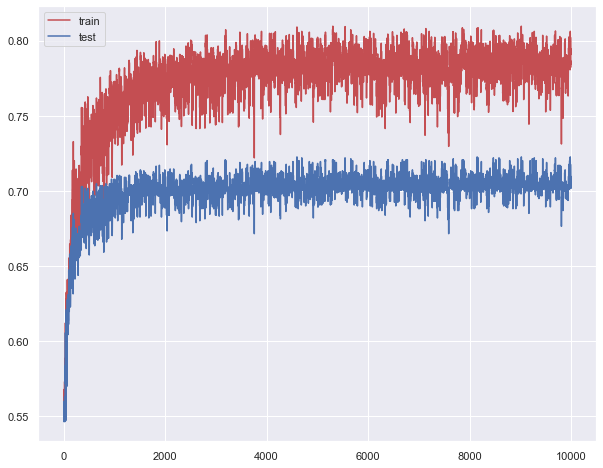

In [109]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', label='train')
plt.plot(test_scores, 'b', label='test')
plt.legend()

In [110]:
# Получите индексы фичей
pos_features = np.argsort(clf.w)[-100:]
neg_features = np.argsort(clf.w)[:100]
print(pos_features)
print(neg_features)

[18870  5937 11417  2428  1751  3558  1324 16826  9414  8167 11878  1319
  2405  1961  6819 13333 15141  5058 16708  5017  9451    81 16052  2172
  2671  1841  1609 11575 14856 13940  8399 13376  1608  1648  3730 15131
 14325 18974   798 15942  1591  2126 16169 14816 12244  7488  3684 18469
  6016  4506 13785  4183  1508 11574  1578  4538   693  3192 15514 14161
 14812  8312  4529  4630  8343 19149  7022  2049  4524  8028  4597  7799
 11361 15950  2343  6533  7489  8552 12411  1906  8897 12243  3924  9943
  6454  9408  1022  1103  3725 16825  8340 11509 14910  4237 17044 16406
 16162  9942 16791  1815]
[16617  1108  9913 14759  2010 12882  8498  8214  4520 19107 14738  3998
   776  8499  6331  3235 18982 14144 16814   261 14817  3923  2267   375
  4608   987 10217  8492   342 15193  8384  7791   950 14754 17015 15057
 19040 14459  3087 14721  4536 16707  6518 12322   138 15091  9494  8400
 15733  6366  8472 19059 16815 11255  9409  4227   889 15390  4381  1015
  9541  4435 12103  7192 

In [116]:
# Выведите слова
fnames = vectorizer.get_feature_names()
print(len(fnames))
print([fnames[p] for p in pos_features])
print([fnames[n] for n in neg_features])

19175
['экспорт', 'золото', 'планирует', 'быть', 'аналогов', 'выручки', 'xretail', 'тгкmoex', 'новатэка', 'месяцев', 'пока', 'wildberries', 'был', 'банка', 'кзос', 'прогнозная', 'северсталь', 'европе', 'сша', 'других', 'новый', '19', 'спг', 'благодаря', 'весь', 'арктик', 'акция', 'повышение', 'рынке', 'раза', 'может', 'продажа', 'акцию', 'алроса', 'газпромнефти', 'себя', 'рдв', 'эмитент', 'group', 'состав', 'акций', 'бизнеса', 'справедливых', 'русал', 'портфеля', 'куйбышев', 'газа', 'цена', 'из', 'дивдоходность', 'проявили', 'даже', 'азот', 'повышена', 'актуальный', 'дивиденды', 'enel', 'всех', 'следующие', 'распадская', 'русаква', 'мире', 'дивидендный', 'до', 'ммк', 'яндекса', 'компания', 'белуга', 'дивидендного', 'мать', 'дитя', 'лучше', 'пик', 'составит', 'будет', 'источников', 'куйбышевазот', 'на', 'потенциал', 'аэрофлота', 'не', 'портфель', 'года', 'огкmoex', 'искч', 'нлмк', 'neo', 'putinomics', 'газпрома', 'тгк', 'млрд', 'по', 'самолет', 'даунсайд', 'ткс', 'стоимость', 'справедли

In [117]:
pos_words = [fnames[p] for p in pos_features]
pos_res = {}
for word in pos_words:
    for sentense in review_summaries:
        pos_res.setdefault(word, 0)
        pos_res[word] += sentense.count(word)

In [118]:
print(pos_res)

{'экспорт': 219, 'золото': 143, 'планирует': 178, 'быть': 200, 'аналогов': 114, 'выручки': 344, 'xretail': 255, 'тгкmoex': 13, 'новатэка': 179, 'месяцев': 111, 'пока': 510, 'wildberries': 45, 'был': 1057, 'банка': 321, 'кзос': 36, 'прогнозная': 28, 'северсталь': 138, 'европе': 231, 'сша': 268, 'других': 103, 'новый': 119, '19': 80, 'спг': 416, 'благодаря': 225, 'весь': 75, 'арктик': 77, 'акция': 290, 'повышение': 71, 'рынке': 340, 'раза': 407, 'может': 1471, 'продажа': 62, 'акцию': 398, 'алроса': 163, 'газпромнефти': 44, 'себя': 55, 'рдв': 909, 'эмитент': 56, 'group': 392, 'состав': 1073, 'акций': 1117, 'бизнеса': 197, 'справедливых': 47, 'русал': 314, 'портфеля': 268, 'куйбышев': 206, 'газа': 298, 'цена': 655, 'из': 4194, 'дивдоходность': 183, 'проявили': 17, 'даже': 201, 'азот': 265, 'повышена': 59, 'актуальный': 226, 'дивиденды': 397, 'enel': 57, 'всех': 154, 'следующие': 121, 'распадская': 12, 'русаква': 73, 'мире': 227, 'дивидендный': 236, 'до': 6284, 'ммк': 151, 'яндекса': 190, '

In [119]:
neg_words = [fnames[p] for p in neg_features]
neg_res = {}
for word in neg_words:
    for sentense in review_summaries:
        neg_res.setdefault(word, 0)
        neg_res[word] += sentense.count(word)

In [120]:
print(neg_res)

{'сургутнефтегаз': 457, 'qiwi': 87, 'обычка': 104, 'руб': 3608, 'башнефть': 76, 'преф': 588, 'мсфо': 277, 'мечел': 108, 'дивидендах': 131, 'юнипро': 227, 'ростелеком': 215, 'госа': 99, 'globaltrans': 60, 'мтс': 546, 'интер': 440, 'втб': 243, 'энел': 156, 'рао': 184, 'татнефть': 144, '3кв2021': 29, 'русала': 136, 'год': 3726, 'больших': 43, '6мес2020': 35, 'для': 1049, 'moex': 964, 'операционные': 105, 'мр': 400, '5g': 52, 'селигдар': 27, 'могут': 435, 'лукойл': 268, 'mail': 322, 'рсбу': 78, 'техов': 11, 'своих': 77, 'эталон': 59, 'результаты': 262, 'воса': 36, 'российских': 130, 'дивидендом': 135, 'счёт': 128, 'исторические': 12, 'поставлена': 12, '2020': 278, 'сд': 383, 'норникель': 212, 'можно': 301, 'совкомфлот': 104, 'интеррао': 32, 'мосэнерго': 95, 'этого': 175, 'таттелеком': 34, 'пересмотр': 32, 'нмтп': 56, 'данных': 53, 'iкв2021': 98, 'скажется': 43, 'день': 305, 'nasdaq': 46, 'оа': 26, 'детского': 137, 'полюса': 57, 'конференц': 77, 'мира': 191, 'максимумы': 23, 'русгидро': 152

In [124]:
from wordcloud import WordCloud, STOPWORDS 

In [131]:
neg_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(' '.join(neg_res))

In [132]:
pos_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(' '.join(pos_res))

In [129]:
def plot_cloud(wordcloud): 
    # Set figure size 
    plt.figure(figsize=(40, 30)) 
    # Display image 
    plt.imshow(wordcloud)  
    # No axis details 
    plt.axis("off") 

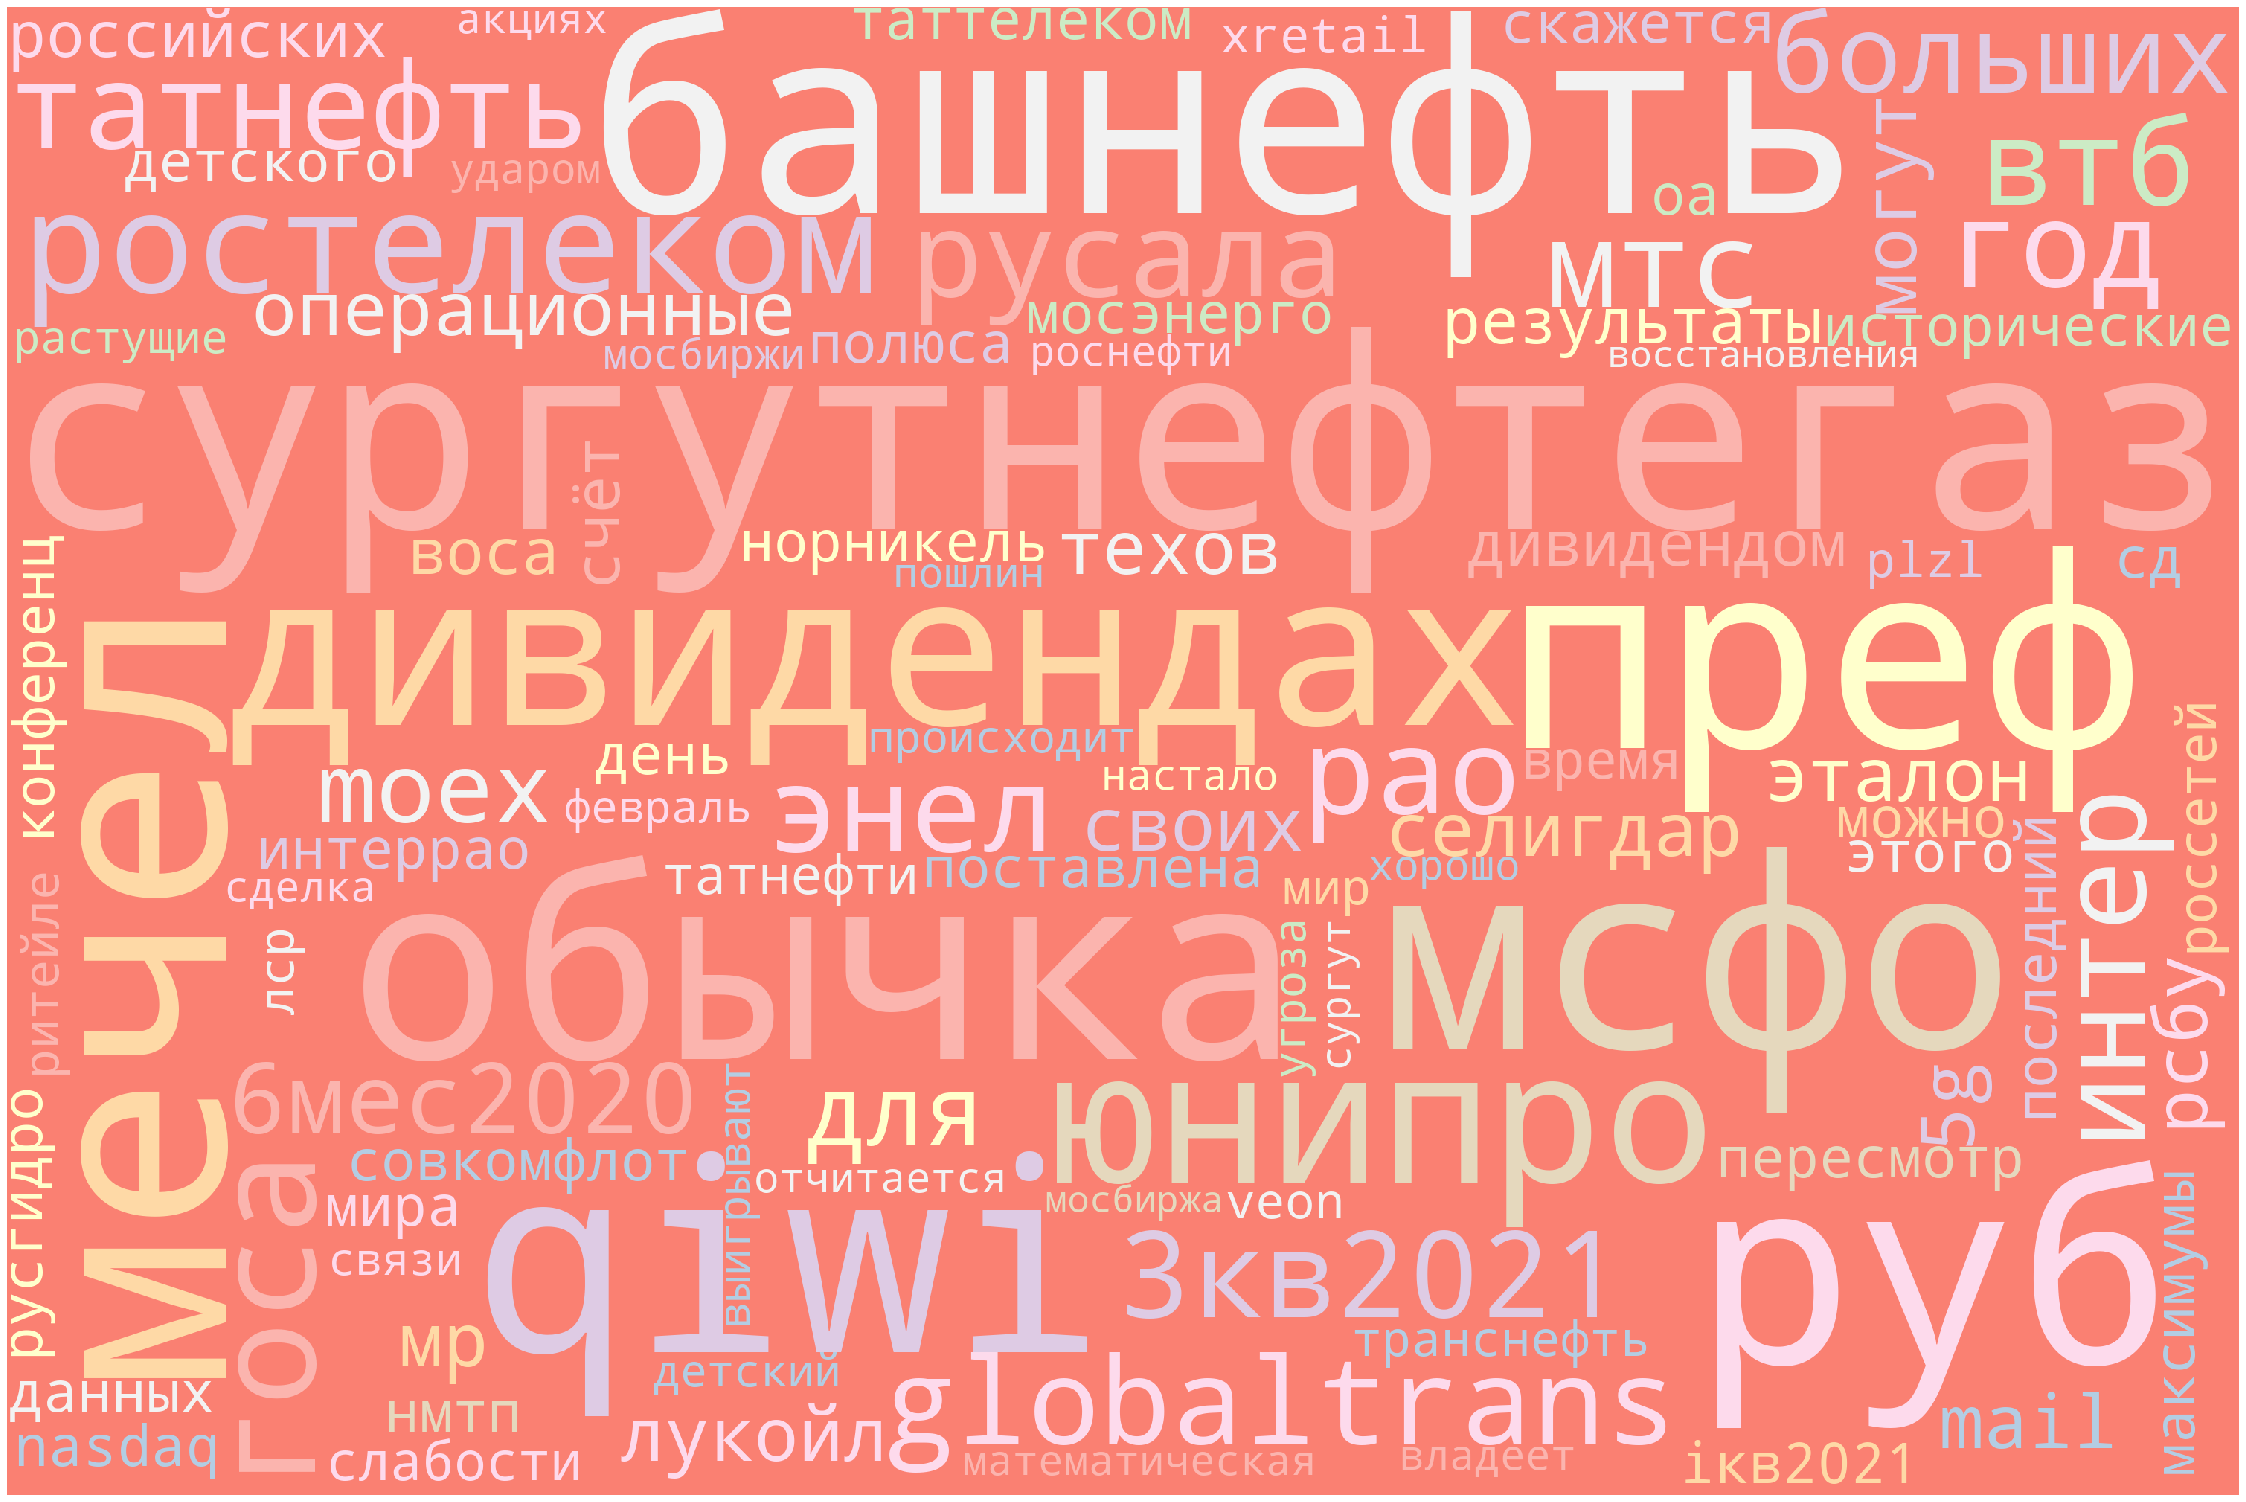

In [130]:
plot_cloud(neg_wordcloud)

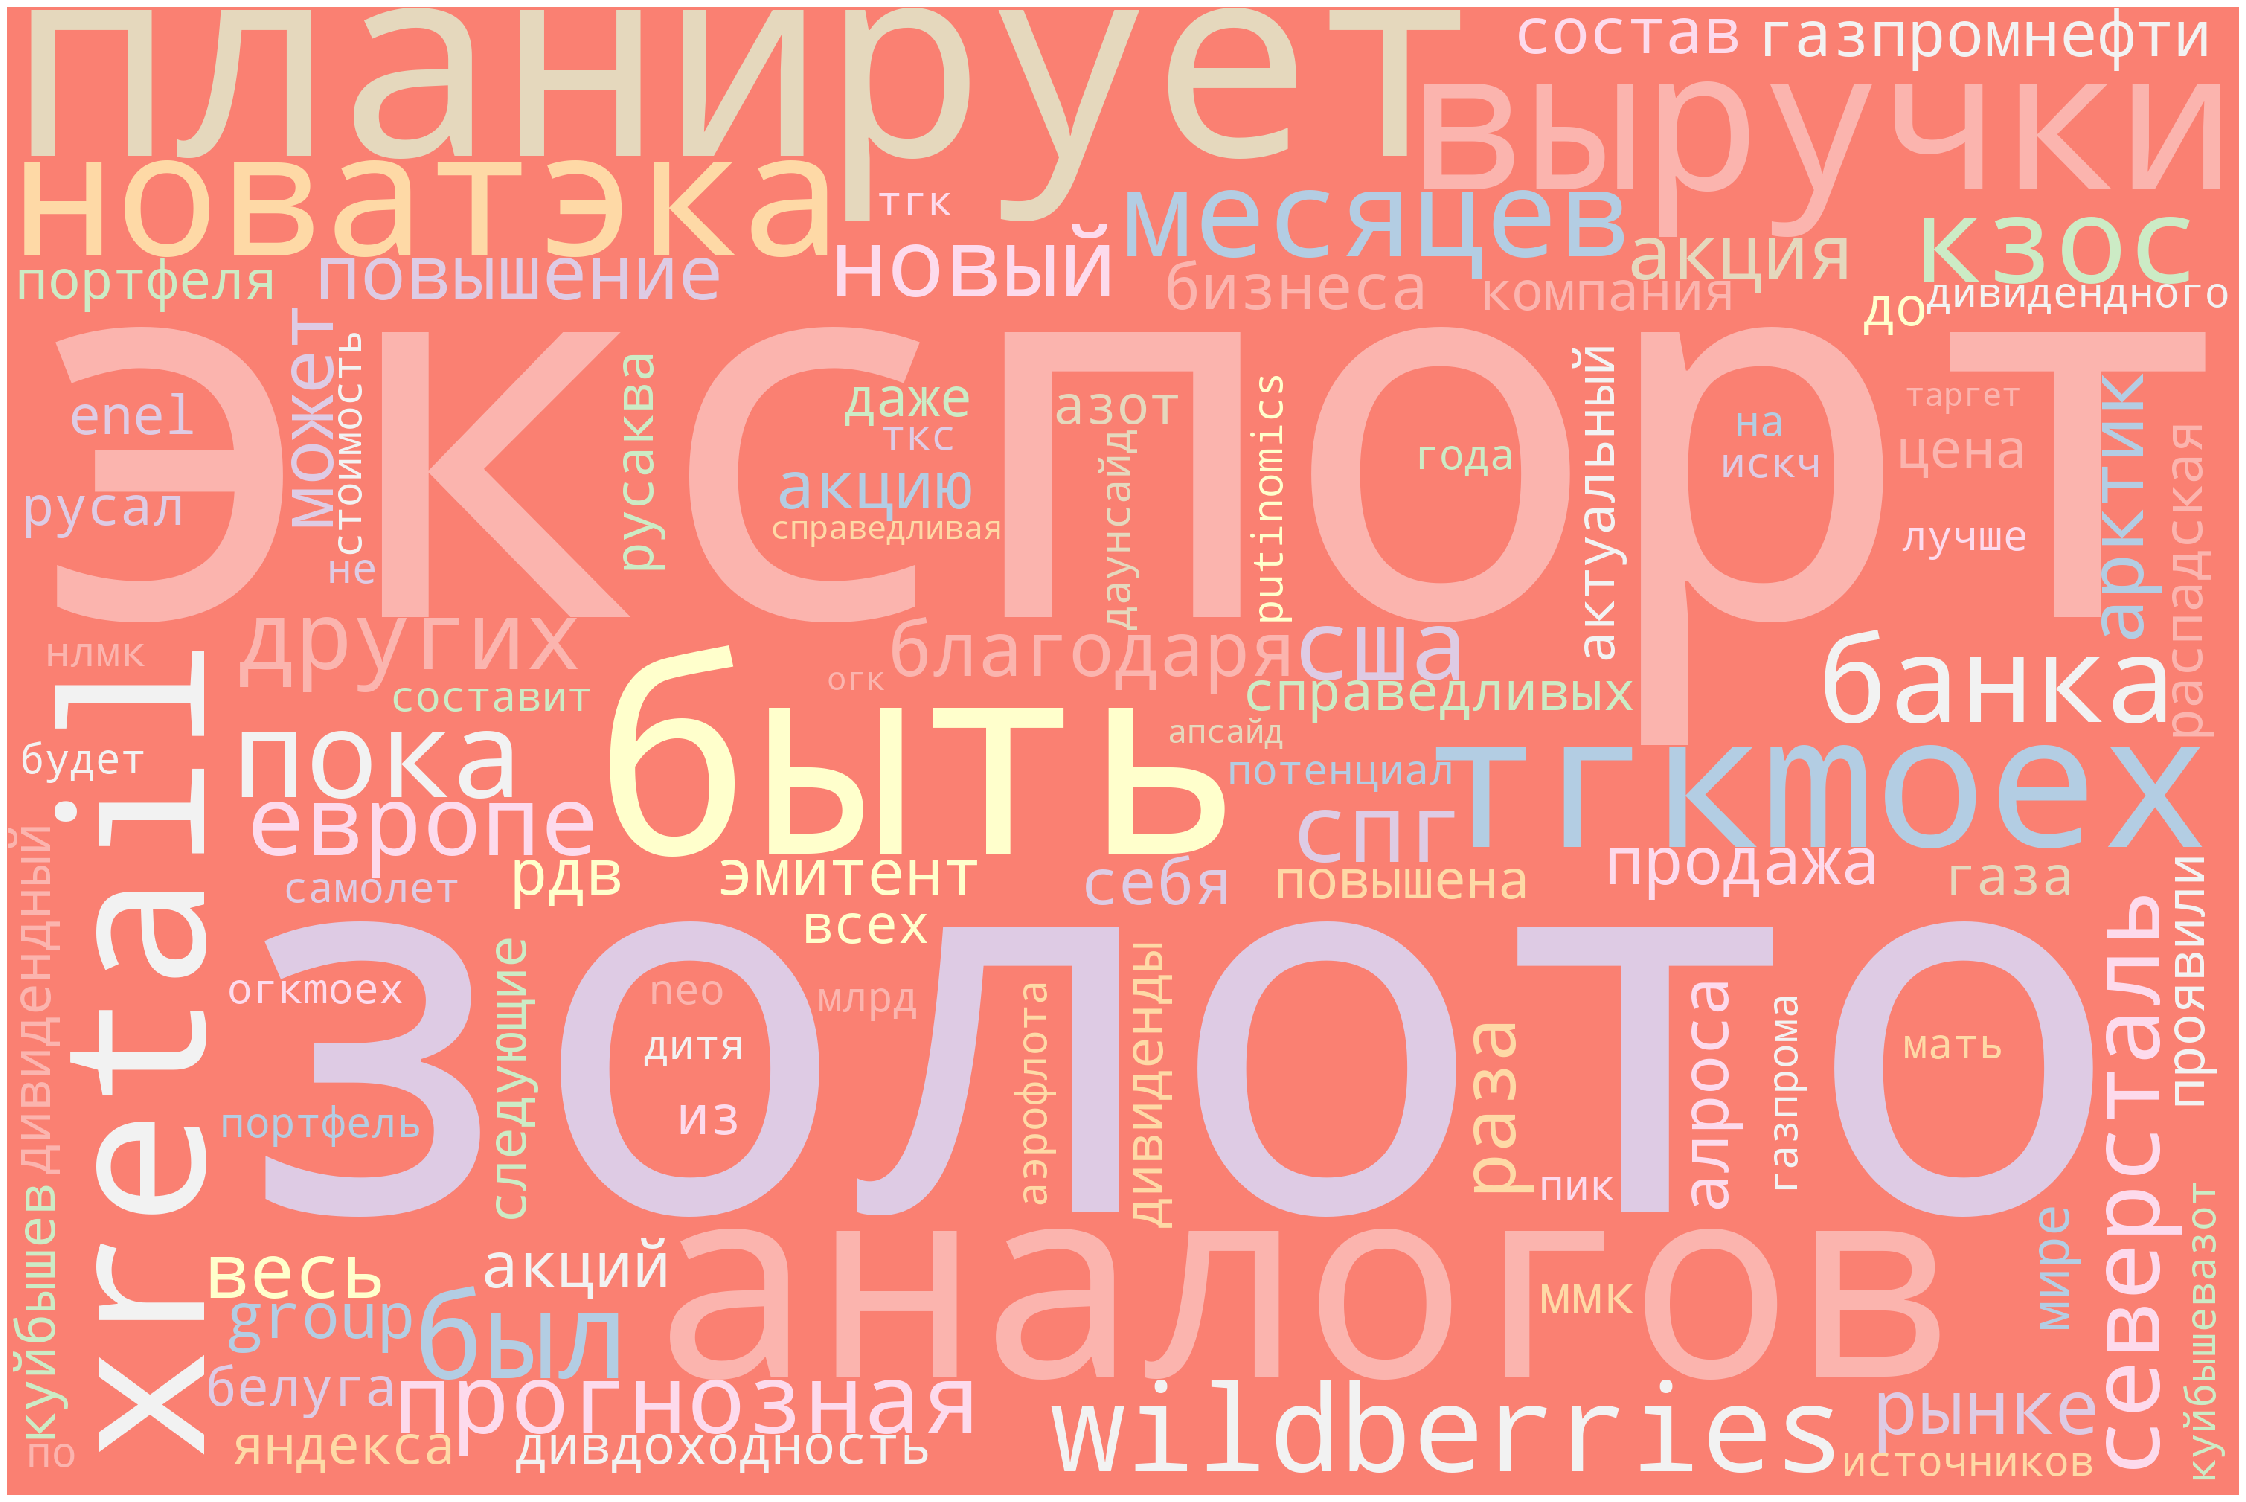

In [133]:
plot_cloud(pos_wordcloud)

In [87]:
# Обучите модель
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(review_summaries)
y = train_df['up_class'].values
clf = LogisticRegression()
clf.train(X, y, verbose=True, learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3)

iteration 0 / 1000: loss 0.694119
iteration 100 / 1000: loss 0.648309
iteration 200 / 1000: loss 0.627619
iteration 300 / 1000: loss 0.623704
iteration 400 / 1000: loss 0.615558
iteration 500 / 1000: loss 0.608264
iteration 600 / 1000: loss 0.595992
iteration 700 / 1000: loss 0.622461
iteration 800 / 1000: loss 0.612439
iteration 900 / 1000: loss 0.622262


In [24]:
len(clf.w)

3001

In [26]:
fnames = vectorizer.get_feature_names()
print(len(fnames))

3000


In [61]:
# Выведите слова
fnames = vectorizer.get_feature_names()
print([fnames[p-1] for p in pos_features])
print([fnames[n-1] for n in neg_features])

['алроса', 'возглавит', 'aramco', 'весеннем', 'великобритании', 'xretailgroup', 'вечерней', '36', 'агентам', 'весны', 'general', 'биржа', '3к16', 'букмекеров', '2014годах', 'value', 'ecommerce', 'безрисковая', '2кв', 'больных', 'апатитового', 'возбуждают', 'go', '35', 'борьбы', 'coca', '4месяцев', 'urals', 'вносил', 'бюджете', 'nsvz', 'внедрения', 'morgan', 'baltic', 'александра', '14x', '2023году', 'partners', 'бесплатное', 'вами', 'введут', 'samsung', '30', 'driftwood', 'ангарском', 'вероятнее', 'введению', 'бонда', 'атаку', 'большинства', 'бизнесмены', 'sales', '20х', '2020', '9млрд', '2021годы', '2023год', 'анатолий', 'возможном', '44', 'акра', 'ddm', 'вариант', 'stanley', 'van', '1756', 'внебиржевом', '2кви', 'diageo', 'delta', 'аудиториями', 'vix', 'авторитетных', 'buy', 'teleпоказывает', '2022', 'ebitdaх', 'благоприятные', 'monitor', 'августу', 'атаки', 'emea', 'baron', 'веса', 'анализе', '3450', '1п', '1пна', 'аналогично', 'valzdez', 'metro', 'xили', 'бренди', 'covid', 'вечной'

In [65]:
pos_words = [fnames[p-1] for p in pos_features]
pos_res = {}
for word in pos_words:
    for sentense in review_summaries:
        pos_res.setdefault(word, 0)
        pos_res[word] += sentense.count(word)

In [ ]:
neg_words = [fnames[p-1] for p in neg_features]
pos_res = {}
for word in pos_words:
    for sentense in review_summaries:
        pos_res.setdefault(word, 0)
        pos_res[word] += sentense.count(word)

In [66]:
print(pos_res)

{'алроса': 163, 'возглавит': 3, 'aramco': 1, 'весеннем': 1, 'великобритании': 6, 'xretailgroup': 4, 'вечерней': 1, '36': 6, 'агентам': 1, 'весны': 6, 'general': 3, 'биржа': 82, '3к16': 1, 'букмекеров': 6, '2014годах': 2, 'value': 6, 'ecommerce': 1, 'безрисковая': 1, '2кв': 28, 'больных': 6, 'апатитового': 1, 'возбуждают': 1, 'go': 39, '35': 12, 'борьбы': 4, 'coca': 2, '4месяцев': 1, 'urals': 3, 'вносил': 1, 'бюджете': 5, 'nsvz': 1, 'внедрения': 2, 'morgan': 19, 'baltic': 1, 'александра': 1, '14x': 1, '2023году': 1, 'partners': 2, 'бесплатное': 2, 'вами': 66, 'введут': 2, 'samsung': 1, '30': 30, 'driftwood': 1, 'ангарском': 2, 'вероятнее': 2, 'введению': 2, 'бонда': 2, 'атаку': 3, 'большинства': 15, 'бизнесмены': 1, 'sales': 5, '20х': 2, '2020': 278, '9млрд': 1, '2021годы': 4, '2023год': 3, 'анатолий': 1, 'возможном': 13, '44': 8, 'акра': 1, 'ddm': 1, 'вариант': 33, 'stanley': 2, 'van': 7, '1756': 1, 'внебиржевом': 5, '2кви': 2, 'diageo': 4, 'delta': 2, 'аудиториями': 1, 'vix': 2, 'авто

In [28]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

In [29]:
clf = linear_model.SGDClassifier(n_iter_no_change=100, random_state=42, loss="log", penalty="l2", alpha=1e-3, eta0=1.0, learning_rate="adaptive")
clf.fit(X_train, y_train)

C:\Users\amura\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='log',
              max_iter=1000, n_iter_no_change=100, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [30]:
print("Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test)))

Train accuracy = 0.784
Test accuracy = 0.703
